<a href="https://colab.research.google.com/github/lizzij/GFlowNets-DNA-Motif/blob/main/Sequence_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@Author TODO

**Generate multiples of $n=5$ (of maximum length $l=4$)**



$$\mathcal{X} = \{0000, ....,9999\}$$

The numbers are constructed autoregressively starting from an initial state (`[BOS]`) and adding each time a digit between 0 and 9 at the end of the already constructed number. The process continues until a special symbol is generated (`[EOS]`) or until the number is of length $l$. As a reward function, we can decide to give a score of $1$ to the multiple of $n$, and a lower and lower score when the considered number is far from a multiple of $n$. A suitable reward function in this case is $R(x) = \lambda^ { - min \{x-n*q_n(x) \text{, } n*(q_n(x)+1)-x \}}$ where $q_n(x)$ is the quotient of the Euclidean division of $x$ by $n$, and $\lambda > 1$.

For $n=5$ and $\lambda = 2$ :
$R(x) = \left\{
    \begin{array}{ll}
        1 & \mbox{if } x = 5k \\
        2^{-1} & \mbox{if } x=5k+1 \mbox{ or } x=5k+4=5(k+1)-1 \\
        2^{-2} & \mbox{if } x=5k+2 \mbox{ or } x=5k+3=5(k+1)-2
    \end{array} \ (k \in \mathbb{N})
\right.$





$$Z = \sum_{x \in \mathcal{X}}R(x) = \ ...$$

$$\pi(x)=\frac{R(x)}{Z} = \left\{
    \begin{array}{ll}
        \frac{1}{Z} & \mbox{if } x = 5k \\
        \frac{1}{2Z} & \mbox{if } x=5k+1 \mbox{ or } x=5k+4 \\
        \frac{1}{4Z} & \mbox{if } x=5k+2 \mbox{ or } x=5k+3
    \end{array} \ (k \in \mathbb{N})
\right.$$

In [ ]:
import torch

In [ ]:
def reward_function(x, a, lambda_ = 2, R_0 = 1e-6):
    q = x // a 
    return lambda_**-min(x-a*q, a*(q+1)-x) + R_0

def reward_function11(state, a, lambda_ = 2):
    """state : (bs, slen)"""
    r = torch.Tensor([reward_function(s, a, lambda_) for s in [float("".join([str(s_i) for s_i in s])) for s in state.tolist()]])
    return r

def reward_function22(state, a, lambda_ = 2):
    """state : (bs, slen)"""
    r = torch.Tensor([reward_function(s, a, lambda_) for s in state])
    return r

In [ ]:
# n
#reward_coef = 5
reward_coef = 11


vocab = ["0", "1", "2", "3", "4", "5", "6", "7", "8", '9', '.', ','] # # eos and pad tokens
pad_index = 10
eos_index = 10 + 1

vocab_size = len(vocab)
max_length = 4+1  # here 1 is BOS

In [ ]:
xs = torch.arange(0, int("".join(["9"]*max_length)))
all_rewards = reward_function22(xs, reward_coef)
print('total reward', xs, all_rewards.view(-1).logsumexp(0))
true_dist = all_rewards.softmax(0).cpu().numpy()
print('true dist', true_dist)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  


total reward tensor([    0,     1,     2,  ..., 99996, 99997, 99998]) tensor(11.6581)
true dist [2.3511759e-05 8.6494929e-06 8.6494929e-06 ... 8.6494929e-06 8.6494929e-06
 8.6494929e-06]


In [ ]:
tk = torch.tensor(all_rewards).topk(k=20)
modes = tk.indices
print(modes)
print(tk.values)

tensor([121,  77, 110, 154,  44, 143,  88, 198,  11,  55, 165,  22, 176, 132,
        187,  99, 209,  66,  33,   0])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


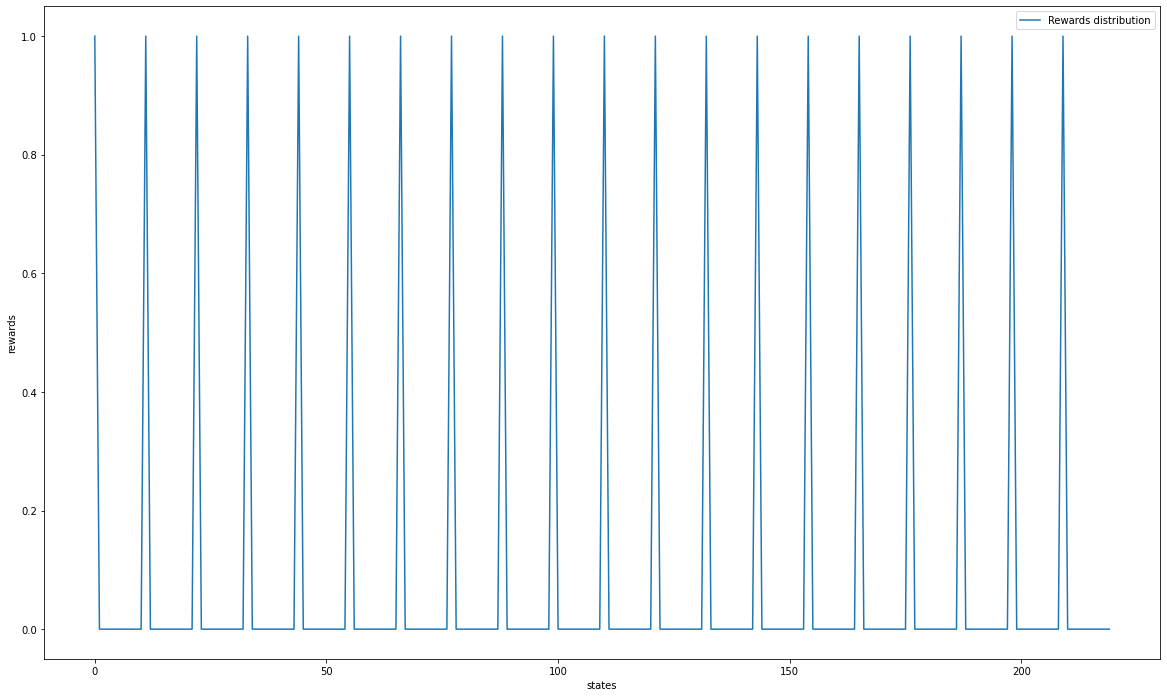

In [ ]:
import matplotlib.pyplot as plt
figsize=(15+5,3*4)
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize = figsize)

# observe 20 modes
ax1.plot(xs[:20*reward_coef], all_rewards[:20*reward_coef], label="Rewards distribution")
ax1.set(xlabel='states', ylabel='rewards')
#ax1.set_title('...')
ax1.legend()

#### Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import itertools
import numpy as np

def Embedding(num_embeddings, embedding_dim, padding_idx=None):
    m = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
    nn.init.normal_(m.weight, mean=0, std=embedding_dim ** -0.5)
    if padding_idx is not None:
        nn.init.constant_(m.weight[padding_idx], 0)
    return m

def get_padding_masks(slen, lengths):
    """
    Generate hidden states mask
    """
    assert lengths.max().item() <= slen
    bs = lengths.size(0)
    alen = torch.arange(slen, dtype=torch.long, device=lengths.device)
    mask = alen < lengths[:, None]
    # sanity check
    assert mask.size() == (bs, slen)
    return mask

class TransformerModel(nn.Module):

    # params : n_words, eos_index, pad_index, emb_dim

    def __init__(self, params, transformer_layers):
        """
        Transformer model 
        """
        super().__init__()
        # embeddings : one hot is better in this case
        self.embeddings = Embedding(params.n_words, params.emb_dim, padding_idx=params.pad_index)
        # This can be replace by transformer model from torch.nn, huggingface transoformer ...
        self.transformer = transformer_layers

    def forward(self, x, lengths):
        """
        Inputs:
            `x` LongTensor(bs, slen), containing word indices
            `lengths` LongTensor(bs), containing the length of each sentence
        """
        #padding_mask = x != self.pad_index
        #lengths = padding_mask.long().sum(dim=1).to(x.device)
        
        # check inputs
        bs, slen = x.size()
        assert lengths.size(0) == bs
        assert lengths.max().item() <= slen

        # generate masks
        mask = get_padding_masks(slen, lengths)

        # embeddings
        tensor = self.embeddings(x)
        tensor *= mask.unsqueeze(-1).to(tensor.dtype)
        
        # transformer layers
        tensor = self.transformer(tensor)
        
        return tensor

In [ ]:
# # For understanding the model
# x = torch.tensor([[1, 2, 3, 4, 4, 4], [2, 3, 4, 4, 4, 4], [0, 1, 1, 3, 4, 4]])
# bs, slen = x.size()
# vocab = ['0', '1', '2', '.', ',']  # "." is EOS, "," is padding 
# vocab_size = len(vocab)
# emb_dim = 7

# class AttrDict(dict):
#     def __init__(self, *args, **kwargs):
#         super(AttrDict, self).__init__(*args, **kwargs)
#         self.__dict__ = self
# params = AttrDict({
#     "n_words": vocab_size,  # num_embeddings (int) – size of the dictionary of embeddings
#     "pad_index" : 4,  
#     "eos_index" : 3, 
#     "emb_dim" : emb_dim,  # embedding_dim (int) – the size of each embedding vector
# })

# # get_padding_masks
# print('get_padding_masks------------')
# padding_mask = x != params.pad_index
# print(padding_mask)
# lengths = padding_mask.long().sum(dim=1).to(x.device)
# print(lengths)
# bs = lengths.size(0)
# alen = torch.arange(slen, dtype=torch.long, device=lengths.device)
# mask = alen < lengths[:, None]
# print(bs)
# print(lengths[:, None])
# print(mask)

# # embedding
# print('\nembedding-------------------')
# embeddings = Embedding(params.n_words, params.emb_dim, padding_idx=params.pad_index)
# print(embeddings)

# # mask + embedding
# print('\nmask + embedding------------')
# tensor = embeddings(x)
# print(tensor)
# tensor *= mask.unsqueeze(-1).to(tensor.dtype)
# print(tensor)

In [ ]:
def make_mlp(l, act=nn.LeakyReLU(), tail=[]):
    """makes an MLP with no top layer activation"""
    return nn.Sequential(*(sum(
        [[nn.Linear(i, o)] + ([act] if n < len(l)-2 else [])
         for n, (i, o) in enumerate(zip(l, l[1:]))], []) + tail))

# Train

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
params = AttrDict({
    "n_words": vocab_size, 
    "pad_index": pad_index, 
    "eos_index": eos_index, 
    "emb_dim": 100, 
})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
Z = torch.ones((1,)).to(device)

n_hid = 256
n_layers = 2

mlp = make_mlp([params.emb_dim] + [n_hid] * n_layers + [params.n_words]).to(device)  # [100, 256, 256, 12]
model = TransformerModel(params, mlp).to(device)
P_B = 1 # DAG & sequence generation => tree 


optim = torch.optim.Adam([ {'params':model .parameters(), 'lr':0.001}, {'params':[Z], 'lr':0.01} ])
Z.requires_grad_()

tensor([1.], requires_grad=True)

In [ ]:
# To understand the model
print([params.emb_dim] + [n_hid] * n_layers + [params.n_words])
print(mlp)
print(model)

[100, 256, 256, 12]
Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=12, bias=True)
)
TransformerModel(
  (embeddings): Embedding(12, 100, padding_idx=10)
  (transformer): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=12, bias=True)
  )
)


In [ ]:
import tqdm

losses_TB = []
zs_TB = []
rewards_TB = []
all_visited_TB = []
first_visit_TB = -1 * np.ones_like(true_dist)
l1log_TB = []

**Here, we are dealing with trees (each non-initial sentence has only one parent), so $P_B = 1 \Rightarrow logP_B = 0$**

In [ ]:
batch_size = 128
max_len = max_length

n_train_steps = 5000

for it in tqdm.trange(n_train_steps):
    generated = torch.LongTensor(batch_size, max_len)  # upcoming output
    generated.fill_(params.pad_index)       # fill upcoming ouput with <PAD>
    generated[:,0].fill_(params.eos_index)    # we use <EOS> for <BOS> everywhere as start token
    #gen_len = (state != params.pad_index).long().sum(dim=1).to(state.device)
    gen_len = torch.LongTensor(batch_size,).fill_(1)
    unfinished_sents = gen_len.clone().fill_(1)
    cur_len = 1
    # Z = Z(agent.model(generated[:,:cur_len], lengths=gen_len, causal=True)[:,0]).squeeze(1).exp().to(device)

    flag = True
    if flag :
        # detached form  of TB
        ll_diff = torch.zeros((batch_size,)).to(device)
        ll_diff += Z
    else :
        # non-detached form of TB ojective, where we multiply everything before doing the logarithm
        in_probs = torch.ones(batch_size, dtype=torch.float, requires_grad=True).to(device)

    while cur_len < max_len:
        state = generated[:,:cur_len] + 0 # (bs, cur_len)
        tensor = model(state.to(device), lengths=gen_len.to(device)) # (bs, cur_len, vocab_size)
        #scores = tensor[:,0] # (bs, vocab_size) : use last word for prediction
        scores = tensor.sum(dim=1) # (bs, vocab_size) 
        scores[:,pad_index] = -1e8 # we don't want to generate pad_token
        scores[:,eos_index] = -1e8 # if we don't want to generate eos_token : don't allow generation of sentences with differents lengths
        scores = scores.log_softmax(1)
        sample_temperature = 1
        probs = F.softmax(scores / sample_temperature, dim=1)
        next_words = torch.multinomial(probs, 1).squeeze(1)

        # update generations / lengths / finished sentences / current length
        generated[:,cur_len] = next_words.cpu() * unfinished_sents + params.pad_index * (1 - unfinished_sents)
        gen_len.add_(unfinished_sents)
        unfinished_sents.mul_(next_words.cpu().ne(params.eos_index).long())
        cur_len = cur_len + 1

        # loss
        if flag :
            #sample_in_probs = probs.gather(1, next_words.unsqueeze(-1)).squeeze(1)
            #sample_in_probs[unfinished_sents == 0] = 1.
            #ll_diff += sample_in_probs.log()
            
            ll_diff += scores.gather(1, next_words.unsqueeze(-1)).squeeze(1)
        else :
            sample_in_probs = probs.gather(1, next_words.unsqueeze(-1)).squeeze(1)
            sample_in_probs[unfinished_sents == 0] = 1.
            in_probs = in_probs * sample_in_probs
      
        # stop when there is a </s> in each sentence, or if we exceed the maximul length
        if unfinished_sents.max() == 0:
            break

    generated = generated.apply_(lambda index : 0 if index == pad_index or index == eos_index else index)
    #R = reward_function(generated, reward_coef).to(device)
    generated =  [float("".join([str(s_i) for s_i in s])) for s in generated.tolist()]
    R = reward_function22(generated, reward_coef).to(device) 
    
    optim.zero_grad()
    if flag :
        ll_diff -= R.log()
        loss = (ll_diff**2).sum()/batch_size
    else :
        loss = ((Z*in_probs / R).log()**2).sum()/batch_size

    loss.backward()
    optim.step()

    losses_TB.append(loss.item())
    zs_TB.append(Z.item())
    rewards_TB.append(R.mean().cpu())
    all_visited_TB.extend(generated)
    for state in all_visited_TB :
        if first_visit_TB[int(state)]<0: first_visit_TB[int(state)] = it

    if it%1000==0: 
        print('loss =', np.array(losses_TB[-100:]).mean(), 'Z =', Z.item(), "R =", np.array(rewards_TB[-100:]).mean() )
        emp_dist = np.bincount(all_visited_TB[-200000:], minlength=len(true_dist)).astype(float)
        emp_dist /= emp_dist.sum()
        l1 = np.abs(true_dist-emp_dist).mean()
        print('L1 =', l1)
        l1log_TB.append((len(all_visited_TB), l1))
        print("gen")
        print(generated[-100:])

  0%|          | 1/5000 [00:00<58:05,  1.43it/s]

loss = 1.2355758833885193 Z = 7.320044040679932 R = 0.26820168
L1 = 1.800032315747208e-05
gen
[4303.0, 3735.0, 2455.0, 3689.0, 5613.0, 4843.0, 5231.0, 7025.0, 2351.0, 7798.0, 3662.0, 783.0, 9724.0, 1981.0, 310.0, 9880.0, 2820.0, 5238.0, 4099.0, 7561.0, 8473.0, 8491.0, 4903.0, 1084.0, 7455.0, 3176.0, 4913.0, 1792.0, 4537.0, 3939.0, 1994.0, 5248.0, 5185.0, 3283.0, 6853.0, 274.0, 3318.0, 5935.0, 1277.0, 7630.0, 9915.0, 2961.0, 8345.0, 7292.0, 4206.0, 3469.0, 1598.0, 8523.0, 6829.0, 5098.0, 6125.0, 8660.0, 8126.0, 5723.0, 1799.0, 4879.0, 1307.0, 9386.0, 1253.0, 3684.0, 2904.0, 6050.0, 6951.0, 3750.0, 3478.0, 9498.0, 2891.0, 8014.0, 8237.0, 6567.0, 6002.0, 1347.0, 3577.0, 4324.0, 7650.0, 6774.0, 9714.0, 732.0, 3456.0, 9447.0, 421.0, 5115.0, 1718.0, 9375.0, 6252.0, 494.0, 380.0, 2706.0, 8974.0, 4747.0, 4133.0, 5516.0, 7283.0, 4228.0, 1723.0, 9198.0, 8941.0, 392.0, 4261.0, 5801.0]


 20%|██        | 1001/5000 [13:41<1:04:38,  1.03it/s]

loss = 1.2330354380607604 Z = 7.331404209136963 R = 0.270023
L1 = 1.800032315747208e-05
gen
[7317.0, 5183.0, 6239.0, 2748.0, 6161.0, 2002.0, 3651.0, 2270.0, 7405.0, 4911.0, 6743.0, 923.0, 8813.0, 427.0, 4434.0, 1391.0, 3483.0, 1419.0, 5837.0, 2311.0, 1911.0, 1564.0, 5070.0, 1082.0, 1353.0, 5389.0, 594.0, 5549.0, 1309.0, 1353.0, 2756.0, 7756.0, 4118.0, 7126.0, 1190.0, 3691.0, 9579.0, 3594.0, 2344.0, 6034.0, 11.0, 3887.0, 8900.0, 5976.0, 5154.0, 410.0, 957.0, 5343.0, 3571.0, 2498.0, 594.0, 1315.0, 8996.0, 3014.0, 3774.0, 8266.0, 40.0, 5724.0, 9262.0, 5695.0, 3883.0, 8987.0, 1475.0, 7075.0, 1955.0, 4915.0, 6705.0, 5714.0, 3974.0, 7401.0, 4738.0, 9008.0, 5907.0, 9008.0, 1869.0, 5003.0, 22.0, 9448.0, 2522.0, 244.0, 9530.0, 8582.0, 5717.0, 2409.0, 4784.0, 4522.0, 2019.0, 3496.0, 4015.0, 4809.0, 7629.0, 454.0, 4038.0, 5465.0, 8746.0, 3138.0, 8804.0, 6660.0, 2008.0, 2789.0]


 40%|████      | 2001/5000 [32:08<1:03:19,  1.27s/it]

loss = 1.2236634427309037 Z = 7.325257301330566 R = 0.2664097
L1 = 1.800032315747208e-05
gen
[5988.0, 5030.0, 4126.0, 4555.0, 5950.0, 2122.0, 9421.0, 8407.0, 3151.0, 3031.0, 4931.0, 3585.0, 8382.0, 4457.0, 3668.0, 3707.0, 5619.0, 6547.0, 6481.0, 9833.0, 9765.0, 93.0, 8537.0, 7224.0, 6762.0, 2882.0, 712.0, 8510.0, 4457.0, 1631.0, 5951.0, 4071.0, 3928.0, 6151.0, 5875.0, 8897.0, 1401.0, 9566.0, 5295.0, 1779.0, 978.0, 2647.0, 6267.0, 6298.0, 5975.0, 148.0, 1315.0, 3980.0, 4828.0, 9604.0, 3419.0, 8042.0, 5075.0, 2491.0, 4683.0, 5282.0, 7320.0, 1494.0, 4829.0, 7182.0, 9572.0, 9877.0, 3498.0, 5385.0, 8558.0, 8692.0, 453.0, 430.0, 2305.0, 5462.0, 3401.0, 1146.0, 7131.0, 7870.0, 3057.0, 8167.0, 684.0, 6689.0, 1043.0, 8278.0, 3204.0, 5711.0, 511.0, 6133.0, 9749.0, 6671.0, 661.0, 9935.0, 1401.0, 5961.0, 4659.0, 1948.0, 5464.0, 8655.0, 8796.0, 9482.0, 6457.0, 3617.0, 6346.0, 6824.0]


 60%|██████    | 3001/5000 [55:21<50:56,  1.53s/it]

loss = 1.2331090331077577 Z = 7.326145172119141 R = 0.266688
L1 = 1.8000323157472082e-05
gen
[1651.0, 8250.0, 5805.0, 7876.0, 6176.0, 3216.0, 5522.0, 939.0, 6836.0, 2430.0, 7880.0, 1251.0, 1553.0, 8047.0, 8657.0, 8161.0, 7952.0, 4404.0, 787.0, 283.0, 1185.0, 5233.0, 9710.0, 7455.0, 6634.0, 9040.0, 5151.0, 8161.0, 245.0, 7547.0, 2274.0, 9061.0, 1594.0, 6000.0, 6309.0, 2249.0, 7168.0, 8959.0, 9836.0, 8601.0, 2092.0, 5404.0, 7569.0, 1435.0, 3466.0, 303.0, 8476.0, 82.0, 837.0, 4791.0, 71.0, 8646.0, 5745.0, 1428.0, 924.0, 7891.0, 2413.0, 2242.0, 625.0, 2374.0, 5719.0, 2753.0, 3067.0, 1122.0, 3473.0, 4087.0, 5783.0, 9285.0, 8129.0, 6655.0, 2302.0, 9493.0, 8278.0, 2135.0, 1764.0, 5942.0, 3585.0, 4010.0, 3950.0, 6225.0, 5631.0, 1767.0, 9379.0, 8602.0, 1305.0, 9482.0, 7885.0, 5931.0, 5487.0, 8399.0, 725.0, 1780.0, 7775.0, 8952.0, 5791.0, 7255.0, 7166.0, 7157.0, 7816.0, 5497.0]


 80%|████████  | 4001/5000 [1:23:15<30:07,  1.81s/it]

loss = 1.2459866279363632 Z = 7.301567077636719 R = 0.26848733
L1 = 1.800032315747208e-05
gen
[8301.0, 3560.0, 4332.0, 2909.0, 6437.0, 4647.0, 4467.0, 3511.0, 7043.0, 8316.0, 8710.0, 1072.0, 5760.0, 2751.0, 6349.0, 4925.0, 5550.0, 9930.0, 1546.0, 4747.0, 8978.0, 3256.0, 8616.0, 5741.0, 8825.0, 4872.0, 6352.0, 6012.0, 4646.0, 812.0, 9310.0, 6874.0, 3405.0, 2435.0, 292.0, 3863.0, 6078.0, 9164.0, 9398.0, 1174.0, 9537.0, 4742.0, 8450.0, 2429.0, 5532.0, 7480.0, 8578.0, 4599.0, 9607.0, 7561.0, 2787.0, 2779.0, 5530.0, 9526.0, 59.0, 3214.0, 6930.0, 5117.0, 1778.0, 6917.0, 1497.0, 1043.0, 137.0, 6328.0, 6742.0, 1437.0, 5101.0, 3863.0, 1772.0, 135.0, 133.0, 4428.0, 6256.0, 190.0, 692.0, 8614.0, 1310.0, 5098.0, 4191.0, 5332.0, 2892.0, 1098.0, 4923.0, 8843.0, 2376.0, 5371.0, 7490.0, 3849.0, 264.0, 8004.0, 6910.0, 4623.0, 8757.0, 1936.0, 7723.0, 1917.0, 4454.0, 8431.0, 7211.0, 7743.0]


100%|██████████| 5000/5000 [1:55:52<00:00,  1.39s/it]


# samples

In [ ]:
samples = []
samples_R = []

for it in tqdm.trange(10):
    generated = torch.LongTensor(batch_size, max_len)  # upcoming output
    generated.fill_(params.pad_index)       # fill upcoming ouput with <PAD>
    generated[:,0].fill_(params.eos_index)    # we use <EOS> for <BOS> everywhere as start token
    #gen_len = (state != params.pad_index).long().sum(dim=1).to(state.device)
    gen_len = torch.LongTensor(batch_size,).fill_(1)
    unfinished_sents = gen_len.clone().fill_(1)
    cur_len = 1
    #Z = Z(agent.model(generated[:,:cur_len], lengths=gen_len, causal=True)[:,0]).squeeze(1).exp().to(device)

    while cur_len < max_len:
        state = generated[:,:cur_len] + 0 # (bs, cur_len)
        tensor = model(state.to(device), lengths=gen_len.to(device)) # (bs, cur_len, vocab_size)
        scores = tensor[:,0] # (bs, vocab_size) : use last word for prediction
        scores[:,pad_index] = -1e2 # we don't want to generate pad_token
        scores[:,eos_index] = -1e2 # if we don't want to generate eos_token : don't allow generation of sentences with differents lengths
        sample_temperature = 1
        probs = F.softmax(scores / sample_temperature, dim=1)
        #next_words = torch.distributions.categorical.Categorical(probs=probs).sample()
        next_words = torch.multinomial(probs, 1).squeeze(1)

        # update generations / lengths / finished sentences / current length
        generated[:,cur_len] = next_words.cpu() * unfinished_sents + params.pad_index * (1 - unfinished_sents)
        gen_len.add_(unfinished_sents)
        unfinished_sents.mul_(next_words.cpu().ne(params.eos_index).long())
        cur_len = cur_len + 1
      
        # stop when there is a </s> in each sentence, or if we exceed the maximul length
        if unfinished_sents.max() == 0:
            break

    generated = generated.apply_(lambda index : 0 if index == pad_index or index == eos_index else index)
    #R = reward_function(generated, reward_coef).to(device)
    generated =  [float("".join([str(s_i) for s_i in s])) for s in generated.tolist()]
    R = reward_function22(generated, reward_coef).to(device) 


    samples.extend(generated)  
    samples_R.extend([r.item() for r in R.cpu()]) 

100%|██████████| 10/10 [00:00<00:00, 106.11it/s]


In [ ]:
print(samples)

[2556.0, 7745.0, 9995.0, 8092.0, 1862.0, 4701.0, 3102.0, 6844.0, 3775.0, 6307.0, 6076.0, 6479.0, 4563.0, 3759.0, 2143.0, 9799.0, 1420.0, 8696.0, 8688.0, 9158.0, 9544.0, 4581.0, 8483.0, 1462.0, 6599.0, 6735.0, 7679.0, 4386.0, 4537.0, 7546.0, 7057.0, 5977.0, 7964.0, 3604.0, 1694.0, 2668.0, 893.0, 874.0, 8587.0, 5421.0, 1263.0, 4092.0, 7481.0, 9405.0, 9934.0, 4800.0, 6234.0, 808.0, 5556.0, 6424.0, 3905.0, 8788.0, 8105.0, 887.0, 8269.0, 5357.0, 6326.0, 6546.0, 310.0, 6014.0, 5057.0, 6650.0, 6052.0, 9163.0, 7271.0, 7248.0, 7682.0, 8495.0, 3247.0, 2357.0, 7474.0, 7363.0, 7512.0, 2679.0, 7027.0, 6663.0, 5684.0, 6974.0, 2603.0, 2561.0, 2622.0, 8862.0, 4387.0, 9023.0, 1125.0, 7187.0, 9318.0, 1115.0, 7138.0, 7300.0, 7160.0, 1626.0, 4665.0, 5998.0, 9935.0, 8589.0, 6422.0, 7568.0, 6804.0, 5741.0, 3426.0, 7999.0, 8411.0, 8816.0, 4754.0, 2124.0, 8429.0, 110.0, 7999.0, 921.0, 1510.0, 5846.0, 5992.0, 1915.0, 28.0, 9458.0, 8334.0, 5213.0, 1269.0, 4594.0, 4082.0, 6872.0, 1834.0, 4600.0, 1982.0, 6197.0, 

In [ ]:
print(samples_R)

[0.06250099837779999, 0.5000010132789612, 0.06250099837779999, 0.06250099837779999, 0.1250009983778, 0.06250099837779999, 1.0000009536743164, 0.2500010132789612, 0.2500010132789612, 0.06250099837779999, 0.06250099837779999, 1.0000009536743164, 0.2500010132789612, 0.1250009983778, 0.2500010132789612, 0.2500010132789612, 0.5000010132789612, 0.03125099837779999, 0.2500010132789612, 0.03125099837779999, 0.06250099837779999, 0.03125099837779999, 0.2500010132789612, 0.5000010132789612, 0.5000010132789612, 0.1250009983778, 0.5000010132789612, 0.1250009983778, 0.03125099837779999, 1.0000009536743164, 0.03125099837779999, 0.06250099837779999, 1.0000009536743164, 0.06250099837779999, 1.0000009536743164, 0.03125099837779999, 0.2500010132789612, 0.03125099837779999, 0.06250099837779999, 0.2500010132789612, 0.2500010132789612, 1.0000009536743164, 0.5000010132789612, 1.0000009536743164, 0.5000010132789612, 0.06250099837779999, 0.1250009983778, 0.03125099837779999, 0.5000010132789612, 1.0000009536743